In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json

Runs: 50


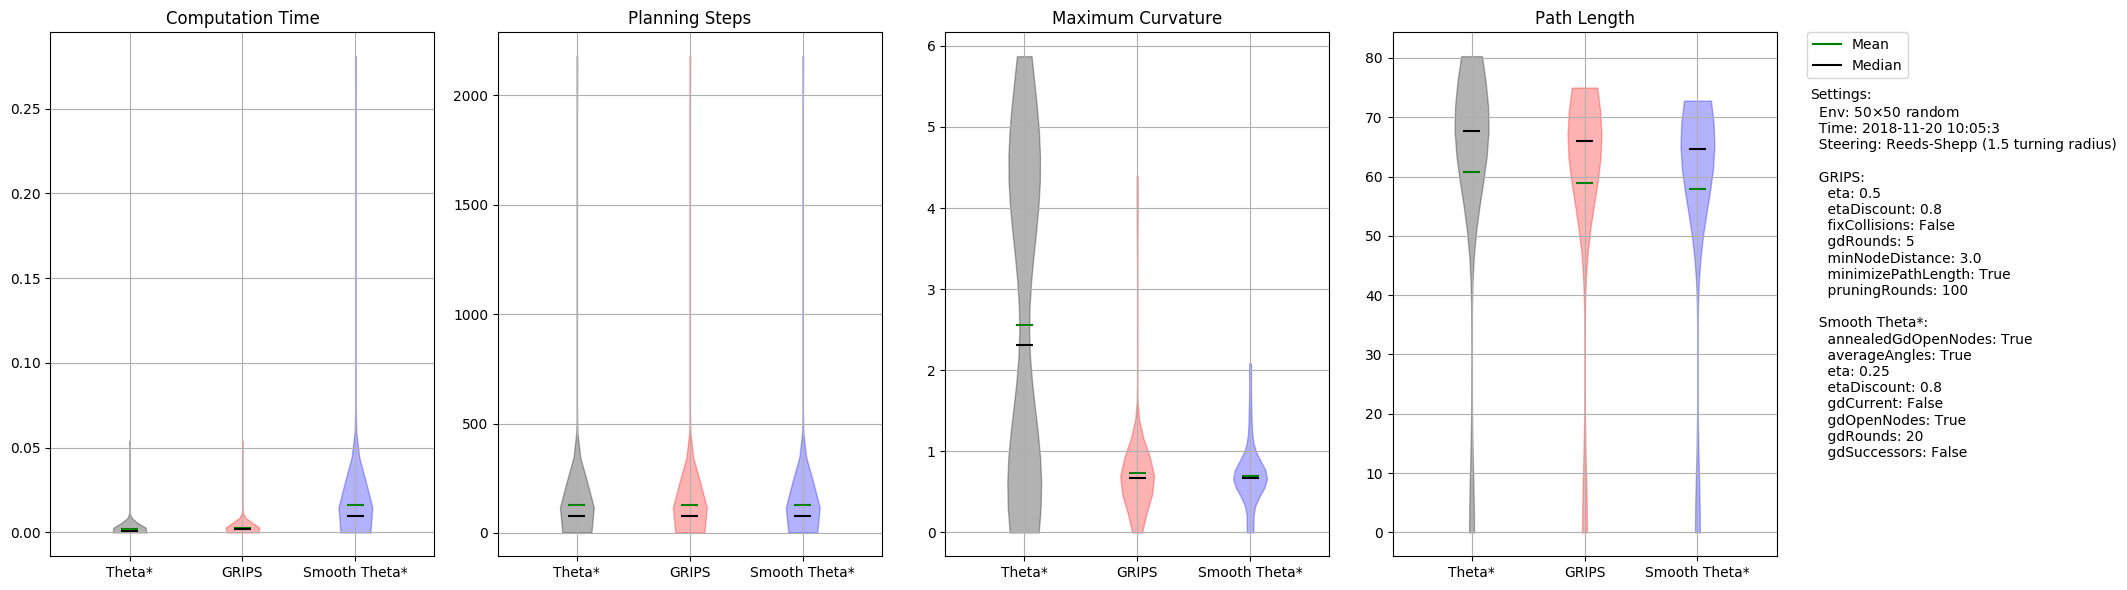

In [3]:
sns.reset_orig()

data = json.load(open("cmake-build-release/log/Reeds-Shepp 50x50 random 1542671305 2018-11-20 10:05:3.json", "r"))

runs = len(data["runs"])
print("Runs:", runs)

def plot_violins(values):
    plt.grid()
    violins = plt.violinplot(values, [0, 1, 2], points=20, widths=0.3,
                          showmeans=True, showextrema=False, showmedians=True)
    violins["bodies"][0].set_facecolor("black")
    violins["bodies"][1].set_facecolor("red")
    violins["bodies"][2].set_facecolor("blue")
    violins["bodies"][0].set_edgecolor("black")
    violins["bodies"][1].set_edgecolor("red")
    violins["bodies"][2].set_edgecolor("blue")
    for partname in ('cmeans','cmedians'):
        violins[partname].set_edgecolor("black")
    violins['cmeans'].set_edgecolor('green')
    plt.gca().set_xlim([-.7, 2.7])
    plt.gca().set_xticks([0, 1, 2])
    plt.gca().set_xticklabels(["Theta*", "GRIPS", "Smooth Theta*"])
    

plt.figure(figsize=(18, 6))
plt.subplot(141)
plt.title("Computation Time")
times = [[e["thetaStar"]["time"] for e in data["runs"]], [e["grips"]["time"] for e in data["runs"]], [e["smoothThetaStar"]["time"] for e in data["runs"]]]
plot_violins(times)

plt.subplot(142)
plt.title("Planning Steps")
steps = [[e["thetaStar"]["steps"] for e in data["runs"]], [e["grips"]["steps"] for e in data["runs"]], [e["smoothThetaStar"]["steps"] for e in data["runs"]]]
plot_violins(steps)

plt.subplot(143)
plt.title("Maximum Curvature")
curvatures = [[e["thetaStar"]["curvature"] for e in data["runs"]], [e["grips"]["curvature"] for e in data["runs"]], [e["smoothThetaStar"]["curvature"] for e in data["runs"]]]
plot_violins(curvatures)

plt.subplot(144)
plt.title("Path Length")
pathLengths = [[e["thetaStar"]["pathLength"] for e in data["runs"]], [e["grips"]["pathLength"] for e in data["runs"]], [e["smoothThetaStar"]["pathLength"] for e in data["runs"]]]
plot_violins(pathLengths)

plt.gca().text(3, 10, "Settings:\n" \
               + ("  Env: %d$\\times$%d %s\n" % (data["environment"]["width"], data["environment"]["height"], data["environment"]["generator"])) \
               + ("  Time: %s\n" % (data["globals"]["time"])) \
               + ("  Steering: %s (%s turning radius)\n\n" % (data["settings"]["steering"], data["settings"]["carTurningRadius"])) \
               + ("  GRIPS:\n%s\n\n" % "\n".join(["    %s: %s" % (key, value) for key, value in data["settings"]["grips"].items()])) \
               + ("  Smooth Theta*:\n%s\n" % "\n".join(["    %s: %s" % (key, value) for key, value in data["settings"]["smoothStar"].items()])) \
)

plt.plot([np.nan], [np.nan], color="green", label="Mean")
plt.plot([np.nan], [np.nan], color="black", label="Median")
plt.legend(bbox_to_anchor=(1.08, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.savefig("gd_only_gd_annealed_average_angles.png", dpi=300)

Skipping the following planners: rrtStar, thetaStar, chomp, sbpl, smoothThetaStar


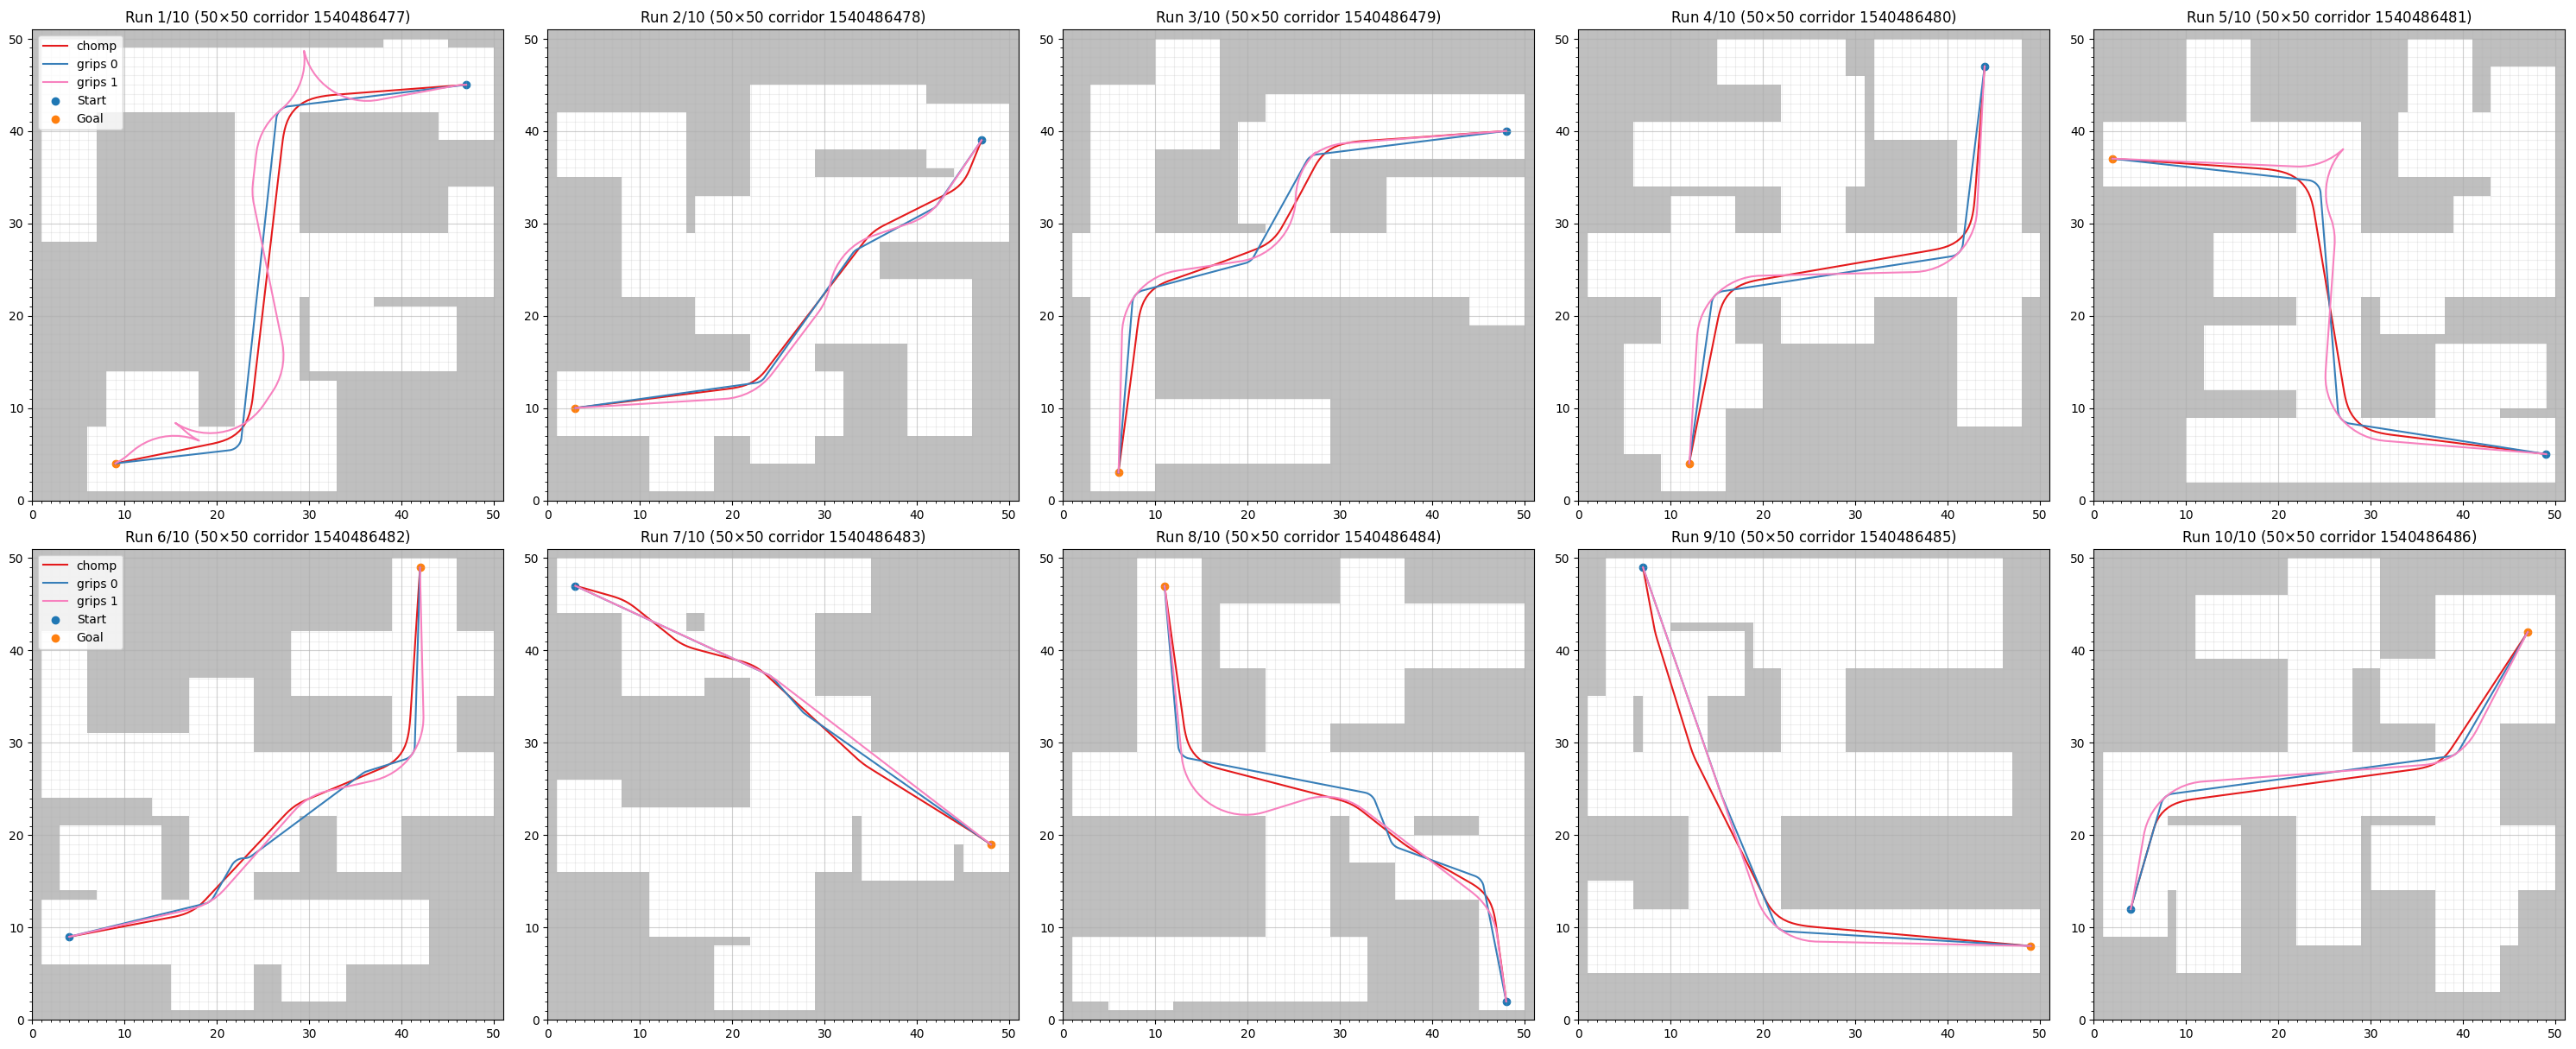

In [35]:
from bitarray import bitarray
from IPython.core.display import display, HTML
import math
import matplotlib.colors as colors
import matplotlib.cm as cmx

data = [
    #json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486477 2018-12-12 11:30:3.json", "r")),
    #json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486477 2018-12-12 11:34:0.json", "r")),
    #json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486477 2018-12-12 11:37:0.json", "r")),
    #json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486477 2018-12-12 11:38:5.json", "r")),
#     json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486477 2018-12-12 18:52:5.json", "r")),
#     json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486477 2018-12-12 19:03:4.json", "r")),
#     json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486477 2018-12-12 19:07:3.json", "r")),
#     json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486477 2018-12-12 19:19:0.json", "r")),
    json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486486 2018-12-12 23:19:3.json", "r")),
#     json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486486 2018-12-12 23:27:2.json", "r")),
    json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486486 2018-12-12 23:31:2.json", "r")),
#     json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486477 2018-12-12 19:46:1.json", "r")),
#     json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486477 2018-12-12 19:48:4.json", "r")),
#     json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486477 2018-12-12 19:52:2.json", "r")),
#     json.load(open("/home/eric/catkin_ws/devel/lib/smooth_star/log/Reeds-Shepp 50x50 corridor 1540486477 2018-12-12 19:54:0.json", "r")),
]

MAX_PLOTS_PER_LINE = 5
SHOW_NODES = False
NODE_ALPHA = 0.5
NUM_COLORS = 7
COLOR_MAP = 'Set1'  # 'Set1'

# do not plot these planners in succeeding benchmarks
skipped_duplicate_planners = ["rrtStar", "thetaStar"]

# definetly show these planners repeatedly for every benchmark
force_duplicate_planners = ["grips"]

# do not plot these planners at all
ignore_planners = ["thetaStar", "rrtStar", "smoothThetaStar"]

axes = [
    ["time", "steps", "curvature", "pathLength"],
    ["meanClearingDistance", "medianClearingDistance", "minClearingDistance", "maxClearingDistance"]
]

axis_labels = [
    ["Computing Time", "Planning Steps", "Maximum Curvature", "Path Length"],
    ["Mean Clearing Distance", "Median Clearing Distance", "Min Clearing Distance", "Max Clearing Distance"]
]

axes_h = MAX_PLOTS_PER_LINE
axes_v = len(data[0]["runs"]) // MAX_PLOTS_PER_LINE + 1

if len(data) > 1:
    # check if environment seeds match between runs
    seeds_0 = tuple([run["environment"]["seed"] for run in data[0]["runs"]])
    for i in range(1, len(data)):
        seeds_i = tuple([run["environment"]["seed"] for run in data[i]["runs"]])
        if seeds_0 != seeds_i:
            display(HTML('<b style="color: #f00">ERROR: Environment seeds between benchmarks 0 and %i do not match!</b>' % i))
            
def dir2table(d):
    table = "<table>"
    for k, v in d.items():
        table += '<tr><td style="text-align:right !important"><b>%s</b></td>' % k
        if isinstance(v, dict):
            table += '<td>' + dir2table(v) + '</td>'
        else:
            table += '<td style="color:#030;text-align:left !important;font-family:monospace !important" align="left">%s</td>' % v
        table += '</tr>'
    table += "</table>"
    return table

def comparison_table(address):
    global skipped_duplicate_planners
    
    def retrieve(benchmark_id, ad):
        d = data[benchmark_id]
        ad = ad.split('/')
        v = d[ad[0]]
        for a in ad[1:]:
            v = v[a]
        return v
    
    table = "<table>"
    d = retrieve(0, address)
    dicts = []
    table += '<tr style="background-color:#003 !important; color:#fff !important"><th style="text-align:left !important">%s</th>' % address + "".join('<th style="text-align:left !important">BM %i</th>' % i for i in range(len(data))) + '</tr>'

    for k, v in d.items():
        curr_address = address + '/' + k
        if isinstance(v, dict):
            dicts.append((k, curr_address, v))
        else:
            table += '<tr><td style="text-align:right !important"><b>%s</b></td>' % k
            for bm in range(len(data)):
                bv = retrieve(bm, curr_address)
                table += '<td style="'
                if v != bv:
                    table += 'color:#069 !important;background-color:#ff4 !important;'
                table += 'text-align:left !important;font-family:monospace !important" align="left">%s</td>' % bv
                
        table += '</tr>'
    for k, a, v in dicts:
        table += '<tr><td style="text-align:right !important"><b>%s</b></td>' % k
        table += '<td colspan="%i">' % (len(data)) + comparison_table(a) + '</td></tr>'
        is_duplicate = True
        for bm in range(1, len(data)):
            bv = retrieve(bm, a)
            if str(v) != str(bv):
                is_duplicate = False
        if is_duplicate and k not in force_duplicate_planners:
            skipped_duplicate_planners.append(k)
        
    table += "</table>"
    return table
            
# print smooth star settings
# table = "<tr><th style='text-align:left !important'>SBPL</th>" + "".join(["<th style='text-align:left !important'>ST %i</th>" % (i+1) for i in range(len(data))]) + "</tr>"
# table += "<tr><td style='vertical-align:top !important'>%s</td>" % dir2table(data[0]["settings"]["sbpl"]) + "".join(["<td style='vertical-align:top !important'>%s</td>" % dir2table(d["settings"]["smoothThetaStar"]) for d in data]) + "</tr>"

if len(data) == 0:
    display(HTML('<table>%s</table>' % dir2table(data[0]["settings"])))
else:
    display(HTML(comparison_table("settings")))
    
print("Skipping the following planners:", ", ".join(skipped_duplicate_planners))

    
cm = plt.get_cmap(COLOR_MAP) 
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
colors = [scalarMap.to_rgba(v) for v in range(NUM_COLORS)]
# colors = ["black", "red", "green", "blue", "lightblue", "cyan", "turquoise", "teal"]

def plot_run(j, i, run, plot_only_trajectories=True):    
    w = run["environment"]["width"] + 1
    h = run["environment"]["height"] + 1
    ax = plt.gca()
    if not plot_only_trajectories:
        major_ticks = np.arange(0, max(w, h), 10)
        minor_ticks = np.arange(0, max(w, h), 1)

        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_yticks(major_ticks)
        ax.set_yticks(minor_ticks, minor=True)

        # And a corresponding grid
        ax.grid(which='both')

        # Or if you want different settings for the grids:
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)

        plt.title("Run %i/%i (%i$\\times$%i %s %i)" % (i+1, len(data[0]["runs"]), w-1, h-1, run["environment"]["generator"], run["environment"]["seed"]))
        map_data = np.array(list(bitarray(run["environment"]["map"]))).reshape((w, h))
        map_data = 1. - np.flip(map_data, axis=0)
        plt.imshow(map_data, cmap='gray', vmin=-1, vmax=1, extent=[0, w, 0, h], alpha=0.5)

        start = run["environment"]["start"]
        goal = run["environment"]["goal"]
        plt.scatter([start[0]], [start[1]], label="Start")
        plt.scatter([goal[0]], [goal[1]], label="Goal")
    
    for ip, (planner, plan) in enumerate(run["plans"].items()):
        if planner in ignore_planners:
            continue
        path = np.array(plan["path"])
        if path.size == 0:
            display(HTML('<b style="color: #f60">Warning: %s did not find a path in run #%i from benchmark %i.</b>' % (planner, i+1, j)))
            continue
        color_id = ip
        if j > 0:
            if planner in skipped_duplicate_planners:
                continue
            else:
                planner += " %i" % j
                color_id = len(run["plans"]) + j
        elif len(data) > 1 and planner not in skipped_duplicate_planners:
            planner += " 0"
        color = colors[color_id % len(colors)]
        plt.plot(path[:, 0], path[:, 1], label=planner, color=color)
        if SHOW_NODES:
            traj = np.array(plan["trajectory"])
            plt.scatter(traj[:, 0], traj[:, 1], color=color, s=10, alpha=NODE_ALPHA)
            for node in plan["trajectory"]:
                dx, dy = math.cos(node[2]), math.sin(node[2])
                plt.arrow(node[0], node[1], dx * 2., dy * 2., color=color, width=0.01, head_width=0.2, alpha=NODE_ALPHA)
    
    if not plot_only_trajectories:
        ax.set_xlim([0, w])
        ax.set_ylim([0, h])

    if i % MAX_PLOTS_PER_LINE == 0:
        plt.legend()
    

plt.figure(figsize=(axes_h * 6, axes_v * 6))
for j, d in enumerate(data):
    for i, run in enumerate(d["runs"]):
        plt.subplot(axes_v, axes_h, i+1)
        plot_run(j, i, run, plot_only_trajectories=(j>0))

plt.tight_layout()
plt.savefig("trajectories.png", dpi=300, bbox_inches='tight')

### 